<a href="https://colab.research.google.com/github/Joizra/Deep-Learning/blob/main/K_Stock_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [271]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [272]:
pip install arch

# Load the dataset

In [273]:
# Specify the path to the 7-Zip archive file
archive_path= '/content/drive/My Drive/Colab Notebooks/Deep Learning/Tesla.csv - Tesla.csv.csv'
data = pd.read_csv(archive_path)


In [274]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [275]:
data = data.iloc[:,:2]


# Data Analysis

In [276]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1692 non-null   object 
 1   Open    1692 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.6+ KB


In [277]:
data.head()

,Date,Open
0,6/29/2010,19.000000
1,6/30/2010,25.790001
2,7/1/2010,25.000000
3,7/2/2010,23.000000
4,7/6/2010,20.000000


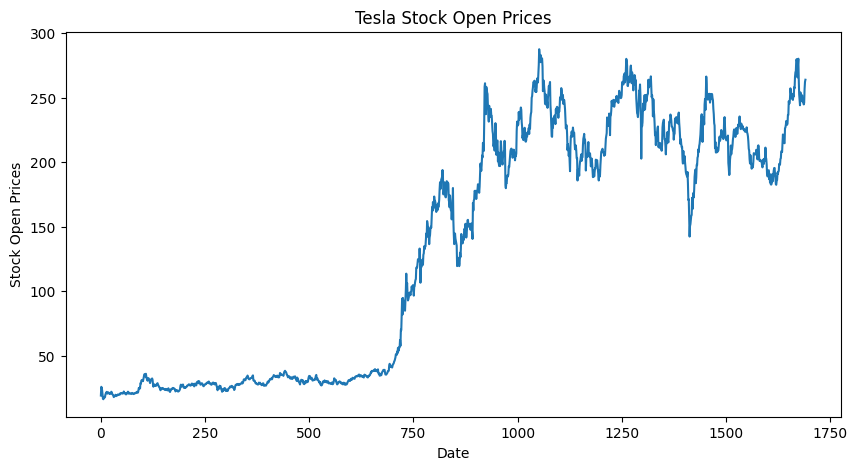

In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it has a column 'Date' with date strings
# and a column 'Open' with the opening stock prices.

data['Date'] = pd.to_datetime(data['Date'])

    # Set the 'Date' column as the index of the DataFrame
#data.set_index('Date', inplace=True)

# Ensure that 'Open' values are positive to avoid issues with logarithm
data['Open'] = data['Open'].clip(lower=0.01)

# Now, the 'Open' column is a time series with the datetime index
open_time_series = data['Open']



# Plot the stationary time series data
plt.figure(figsize=(10, 5))
open_time_series.plot(title='Tesla Stock Open Prices')
plt.xlabel('Date')
plt.ylabel('Stock Open Prices')
plt.show()


# Dataset

In [279]:
data.head()

,Date,Open
0,2010-06-29,19.000000
1,2010-06-30,25.790001
2,2010-07-01,25.000000
3,2010-07-02,23.000000
4,2010-07-06,20.000000


In [280]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 1692
Train data length : 1184
Validation data lenth : 508


In [281]:
train_data = data[:length_train].iloc[:,:2]
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Open
0,2010-06-29,19.000000
1,2010-06-30,25.790001
2,2010-07-01,25.000000
3,2010-07-02,23.000000
4,2010-07-06,20.000000
...,...,...
1179,2015-03-06,199.210007
1180,2015-03-09,194.389999
1181,2015-03-10,188.460007
1182,2015-03-11,191.149994


In [282]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Open
1184,2015-03-13,188.949997
1185,2015-03-16,192.000000
1186,2015-03-17,195.429993
1187,2015-03-18,194.960007
1188,2015-03-19,202.000000
...,...,...
1687,2017-03-13,244.820007
1688,2017-03-14,246.110001
1689,2017-03-15,257.000000
1690,2017-03-16,262.399994


In [283]:
dataset_train = train_data.Open.values
dataset_train.shape

(1184,)

In [284]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(1184, 1)

In [285]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(1184, 1)

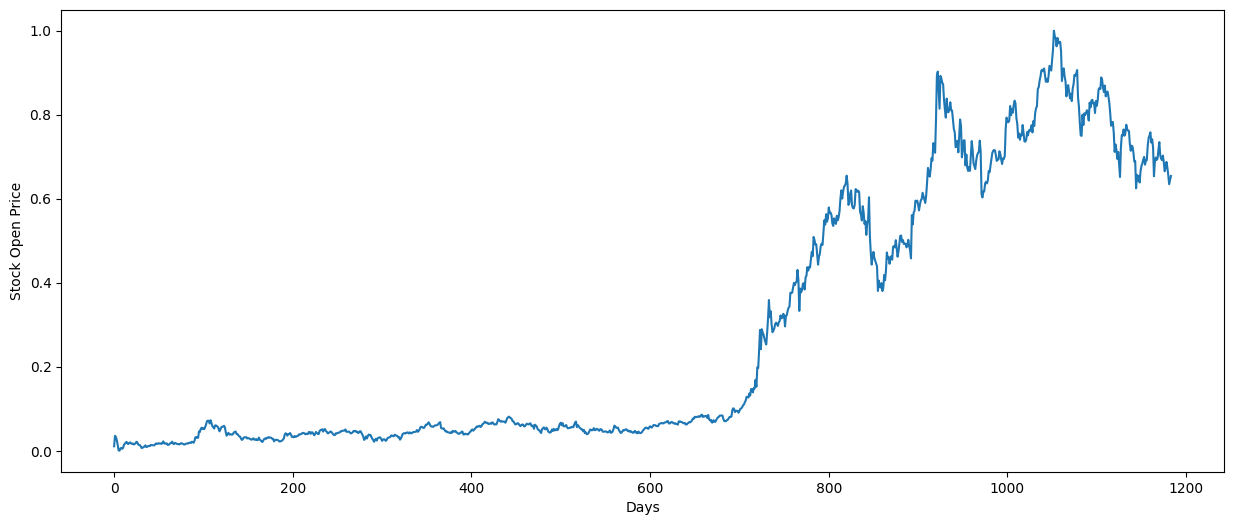

In [286]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days")
plt.ylabel("Stock Open Price")
plt.show()

## Train

In [287]:
X_train = []
y_train = []

time_step = 10

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [288]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (1174, 10)
Shape of y_train before reshape : (1174,)


In [289]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (1174, 10, 1)
Shape of y_train after reshape : (1174, 1)


## Test

In [291]:
dataset_test = np.reshape(validation_data.Open.values, (-1,1))
dataset_test.shape
dataset_test_scaled = scaler.fit_transform(dataset_test)

dataset_test_scaled.shape

(508, 1)

In [292]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(dataset_test_scaled[i-time_step:i,0])
    y_test.append(dataset_test_scaled[i,0])

In [293]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [294]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

# RNN

In [295]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 10,
              activation = "tanh",
              return_sequences = True,
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 10,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 10,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 10)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam",
    loss='mean_squared_error',
    metrics=["mean_squared_error"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 64)

Epoch 1/100
19/19 [==============================] - 4s 33ms/step - loss: 0.2244 - mean_squared_error: 0.2244
Epoch 2/100
19/19 [==============================] - 1s 32ms/step - loss: 0.1521 - mean_squared_error: 0.1521
Epoch 3/100
19/19 [==============================] - 1s 31ms/step - loss: 0.1175 - mean_squared_error: 0.1175
Epoch 4/100
19/19 [==============================] - 1s 32ms/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 5/100
19/19 [==============================] - 1s 31ms/step - loss: 0.0860 - mean_squared_error: 0.0860
Epoch 6/100
19/19 [==============================] - 1s 32ms/step - loss: 0.0719 - mean_squared_error: 0.0719
Epoch 7/100
19/19 [==============================] - 1s 33ms/step - loss: 0.0714 - mean_squared_error: 0.0714
Epoch 8/100
19/19 [==============================] - 1s 34ms/step - loss: 0.0540 - mean_squared_error: 0.0540
Epoch 9/100
19/19 [==============================] - 1s 34ms/step - loss: 0.0605 - mean_squared_error: 0.0605
Epoch 10/1

In [296]:
# Display best accuracy on validation set
max_val_acc = np.min(history.history['mean_squared_error'])
print(f'Best MSE RNN= {max_val_acc:.3f}')   # NB: .3f displays 3 decimal places

# Evaluate
Evaluate_baseline = regressor.evaluate(X_train, y_train)
print(f'MSE RNN= {Evaluate_baseline[1]:.3f}')

Best MSE RNN= 0.005
37/37 [==============================] - 1s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
MSE RNN= 0.001


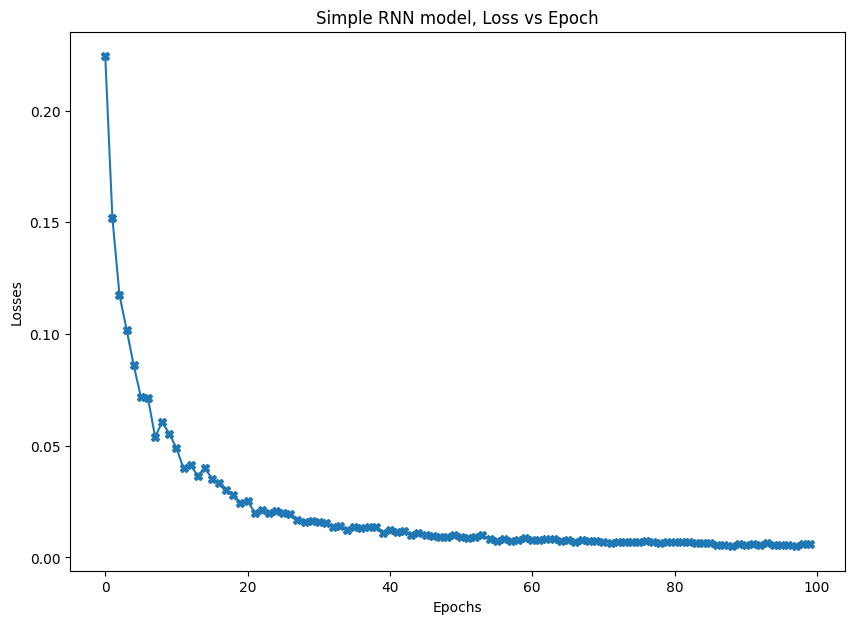

In [297]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"], marker='X')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [298]:
y_performance = regressor.predict(X_train)  # predictions


37/37 [==============================] - 1s 5ms/step


In [299]:
y_pred_performance = scaler.inverse_transform(y_performance) # scaling back from 0-1 to original
y_pred_performance .shape

(1174, 1)

In [300]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(1174, 1)

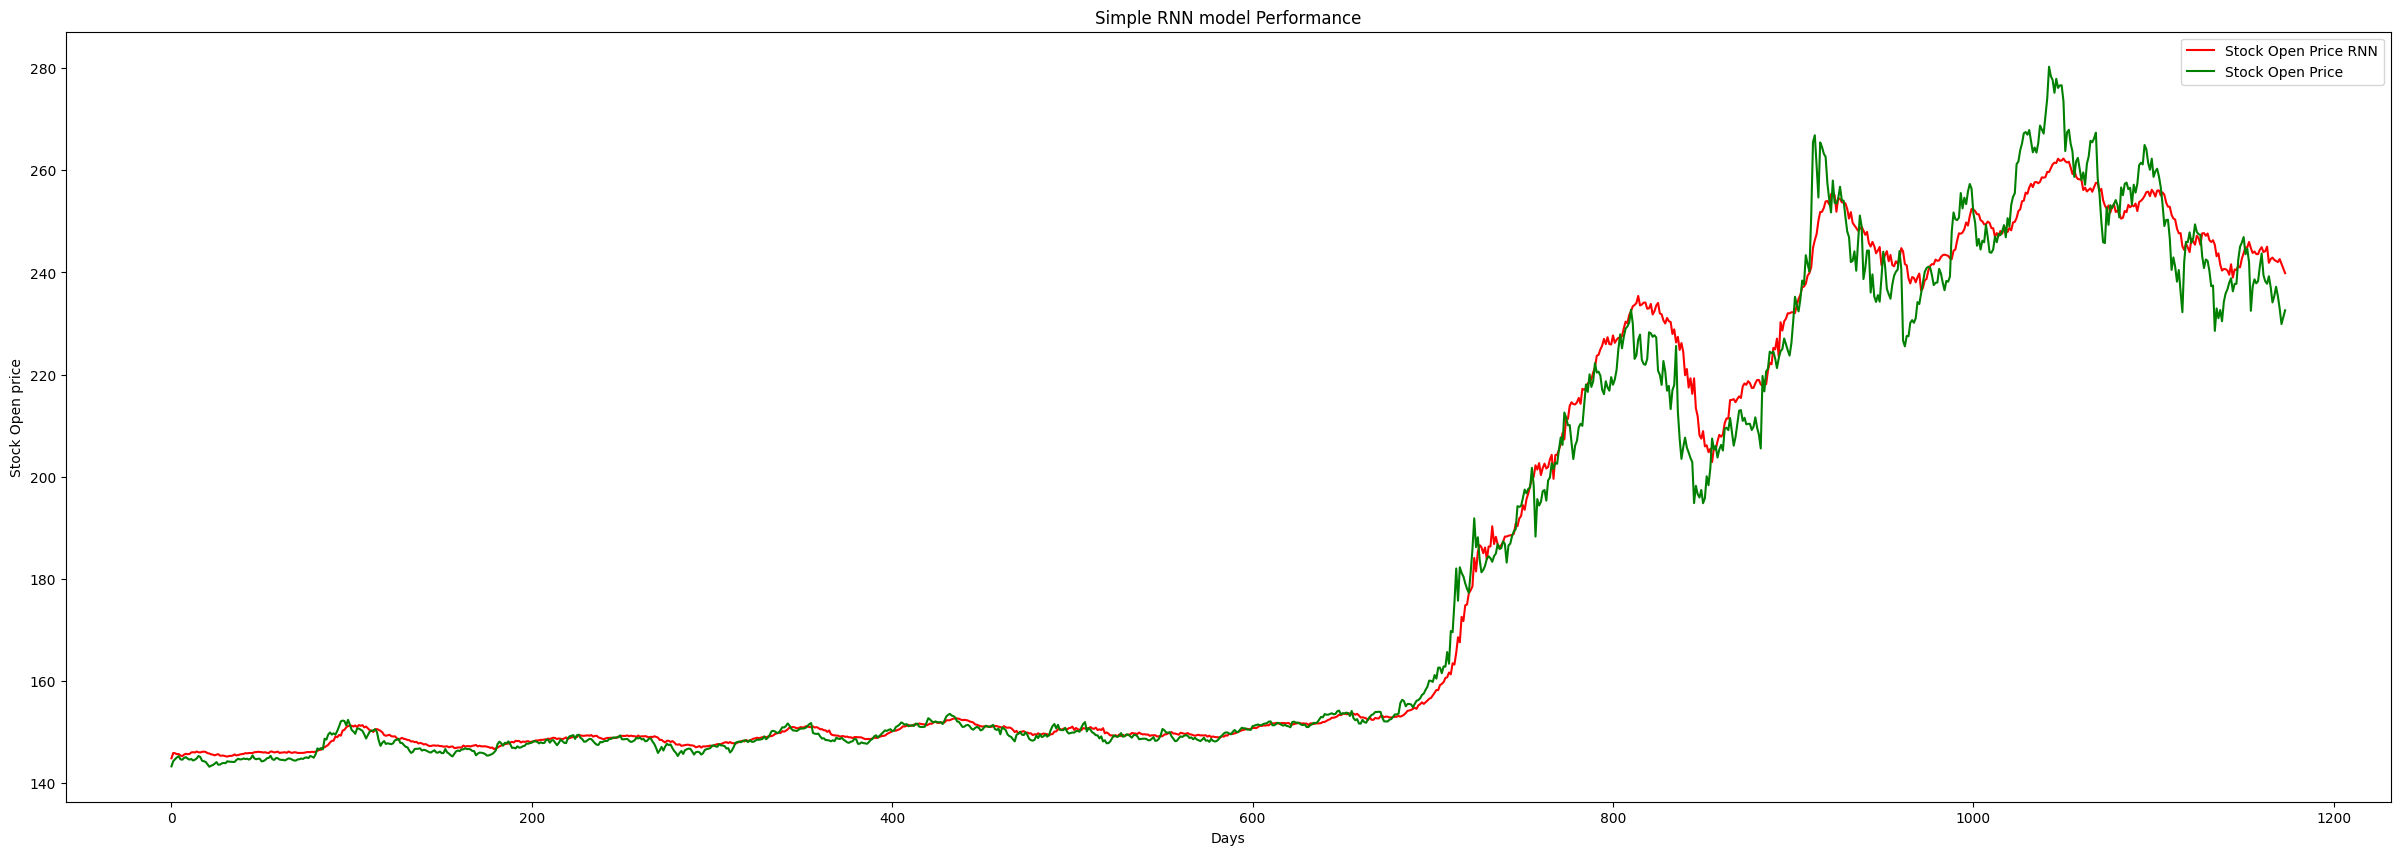

In [301]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_performance , color = "r", label = "Stock Open Price RNN" )
plt.plot(y_train, color = "g", label = "Stock Open Price")
plt.xlabel("Days")
plt.ylabel("Stock Open price")
plt.title("Simple RNN model Performance")
plt.legend()
plt.show()

In [302]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test)
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

16/16 [==============================] - 0s 5ms/step
Shape of y_pred_of_test : (498, 1)


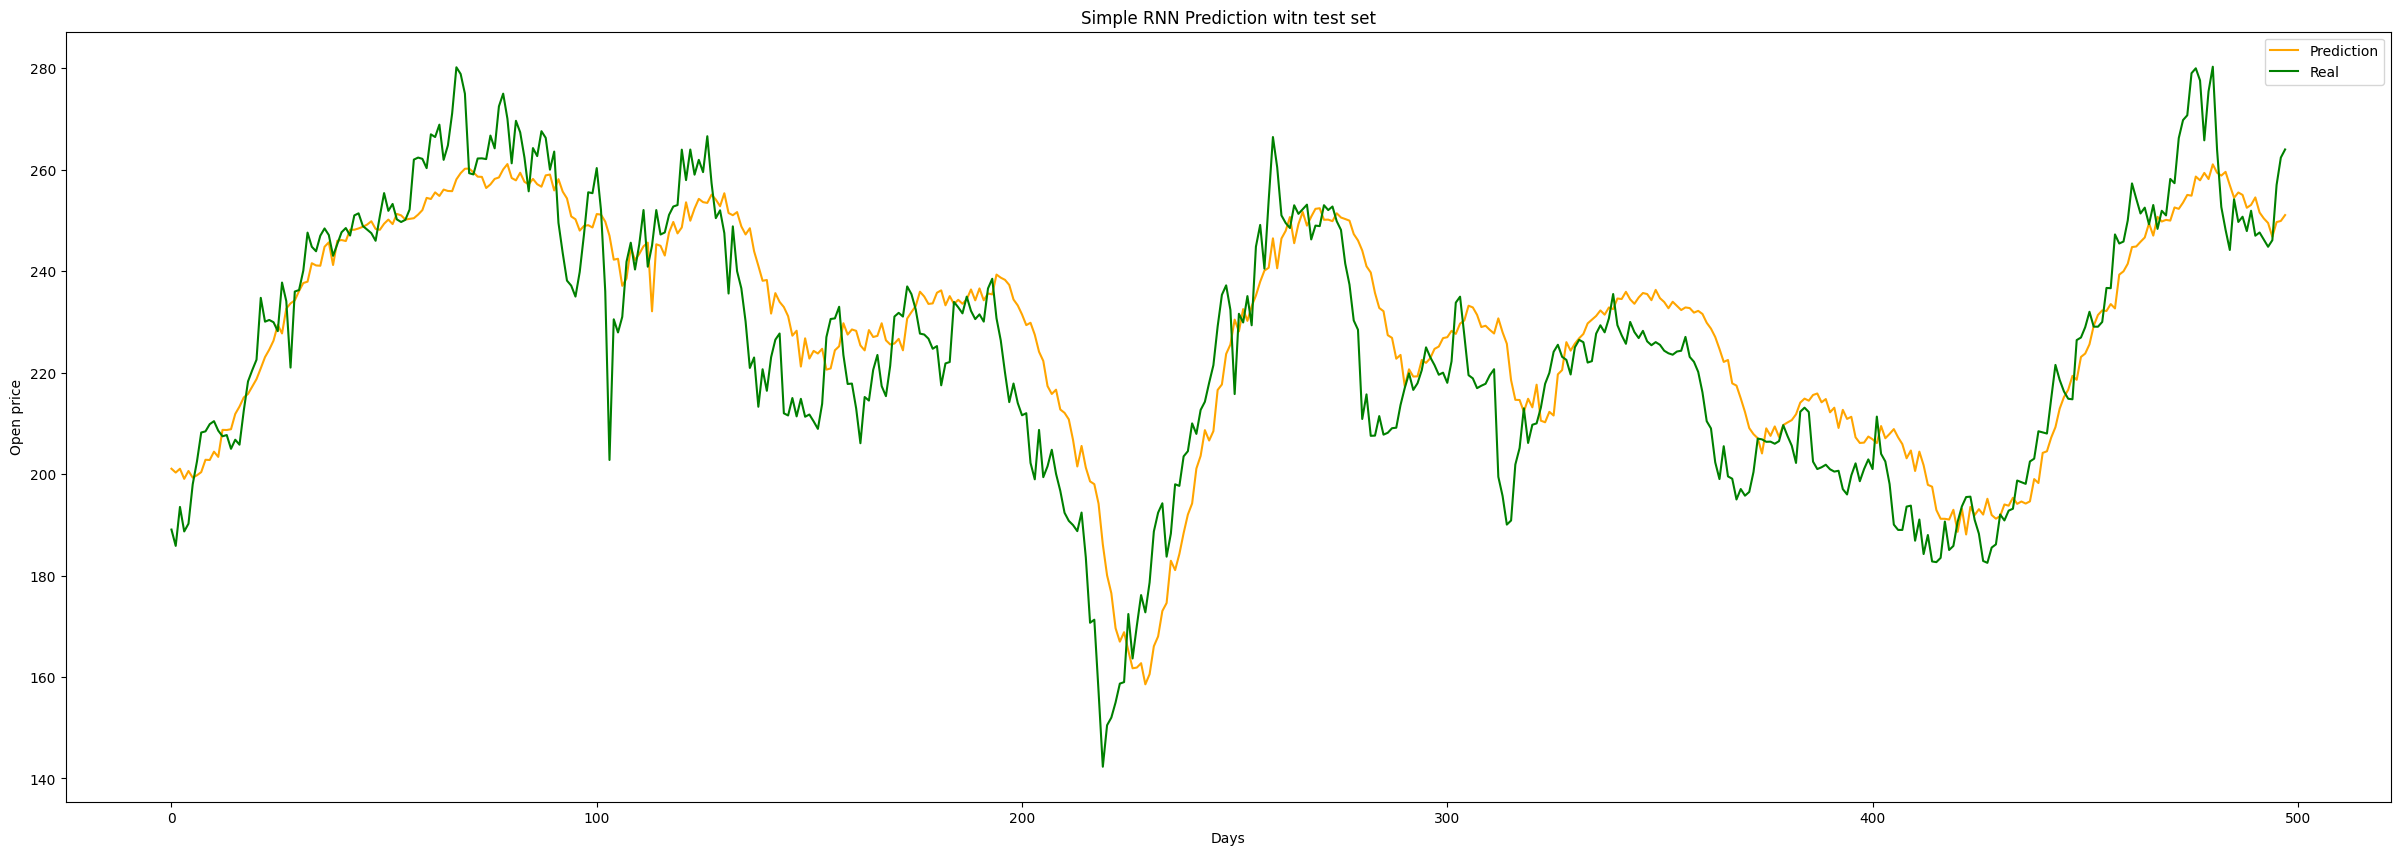

In [303]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "Prediction", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "Real", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN Prediction witn test set")
plt.legend()
plt.show()

# LSTM

In [304]:
y_train = scaler.fit_transform(y_train)

In [305]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(50,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(50, return_sequences= False))
model_lstm.add(Dense(64))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["mean_squared_error"])
history2 = model_lstm.fit(X_train, y_train, epochs = 20, batch_size = 8)

Epoch 1/20
147/147 [==============================] - 4s 6ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 2/20
147/147 [==============================] - 1s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/20
147/147 [==============================] - 1s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 4/20
147/147 [==============================] - 1s 6ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 5/20
147/147 [==============================] - 1s 6ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 6/20
147/147 [==============================] - 1s 6ms/step - loss: 9.3429e-04 - mean_squared_error: 9.3429e-04
Epoch 7/20
147/147 [==============================] - 1s 6ms/step - loss: 9.1597e-04 - mean_squared_error: 9.1597e-04
Epoch 8/20
147/147 [==============================] - 1s 6ms/step - loss: 8.2772e-04 - mean_squared_error: 8.2772e-04
Epoch 9/20
147/147 [==============================] - 1s 6ms/step - loss: 7.7912e-04 - mean_squa

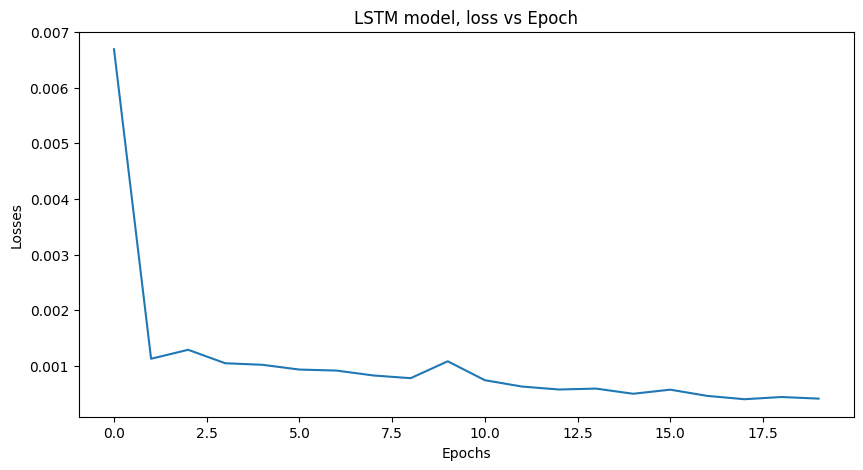

In [306]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, loss vs Epoch")
plt.show()

In [307]:
# Display best accuracy on validation set
max_val_acc = np.min(history2.history['mean_squared_error'])
print(f'Best MSE LSTM: {max_val_acc:.3f}')   # NB: .3f displays 3 decimal places

# Evaluate
Evaluate_baseline = model_lstm.evaluate(X_train, y_train)
print(f'MSE LSTM: {Evaluate_baseline[1]:.3f}')

Best MSE LSTM: 0.000
37/37 [==============================] - 1s 3ms/step - loss: 4.1972e-04 - mean_squared_error: 4.1972e-04
MSE LSTM: 0.000


37/37 [==============================] - 1s 3ms/step


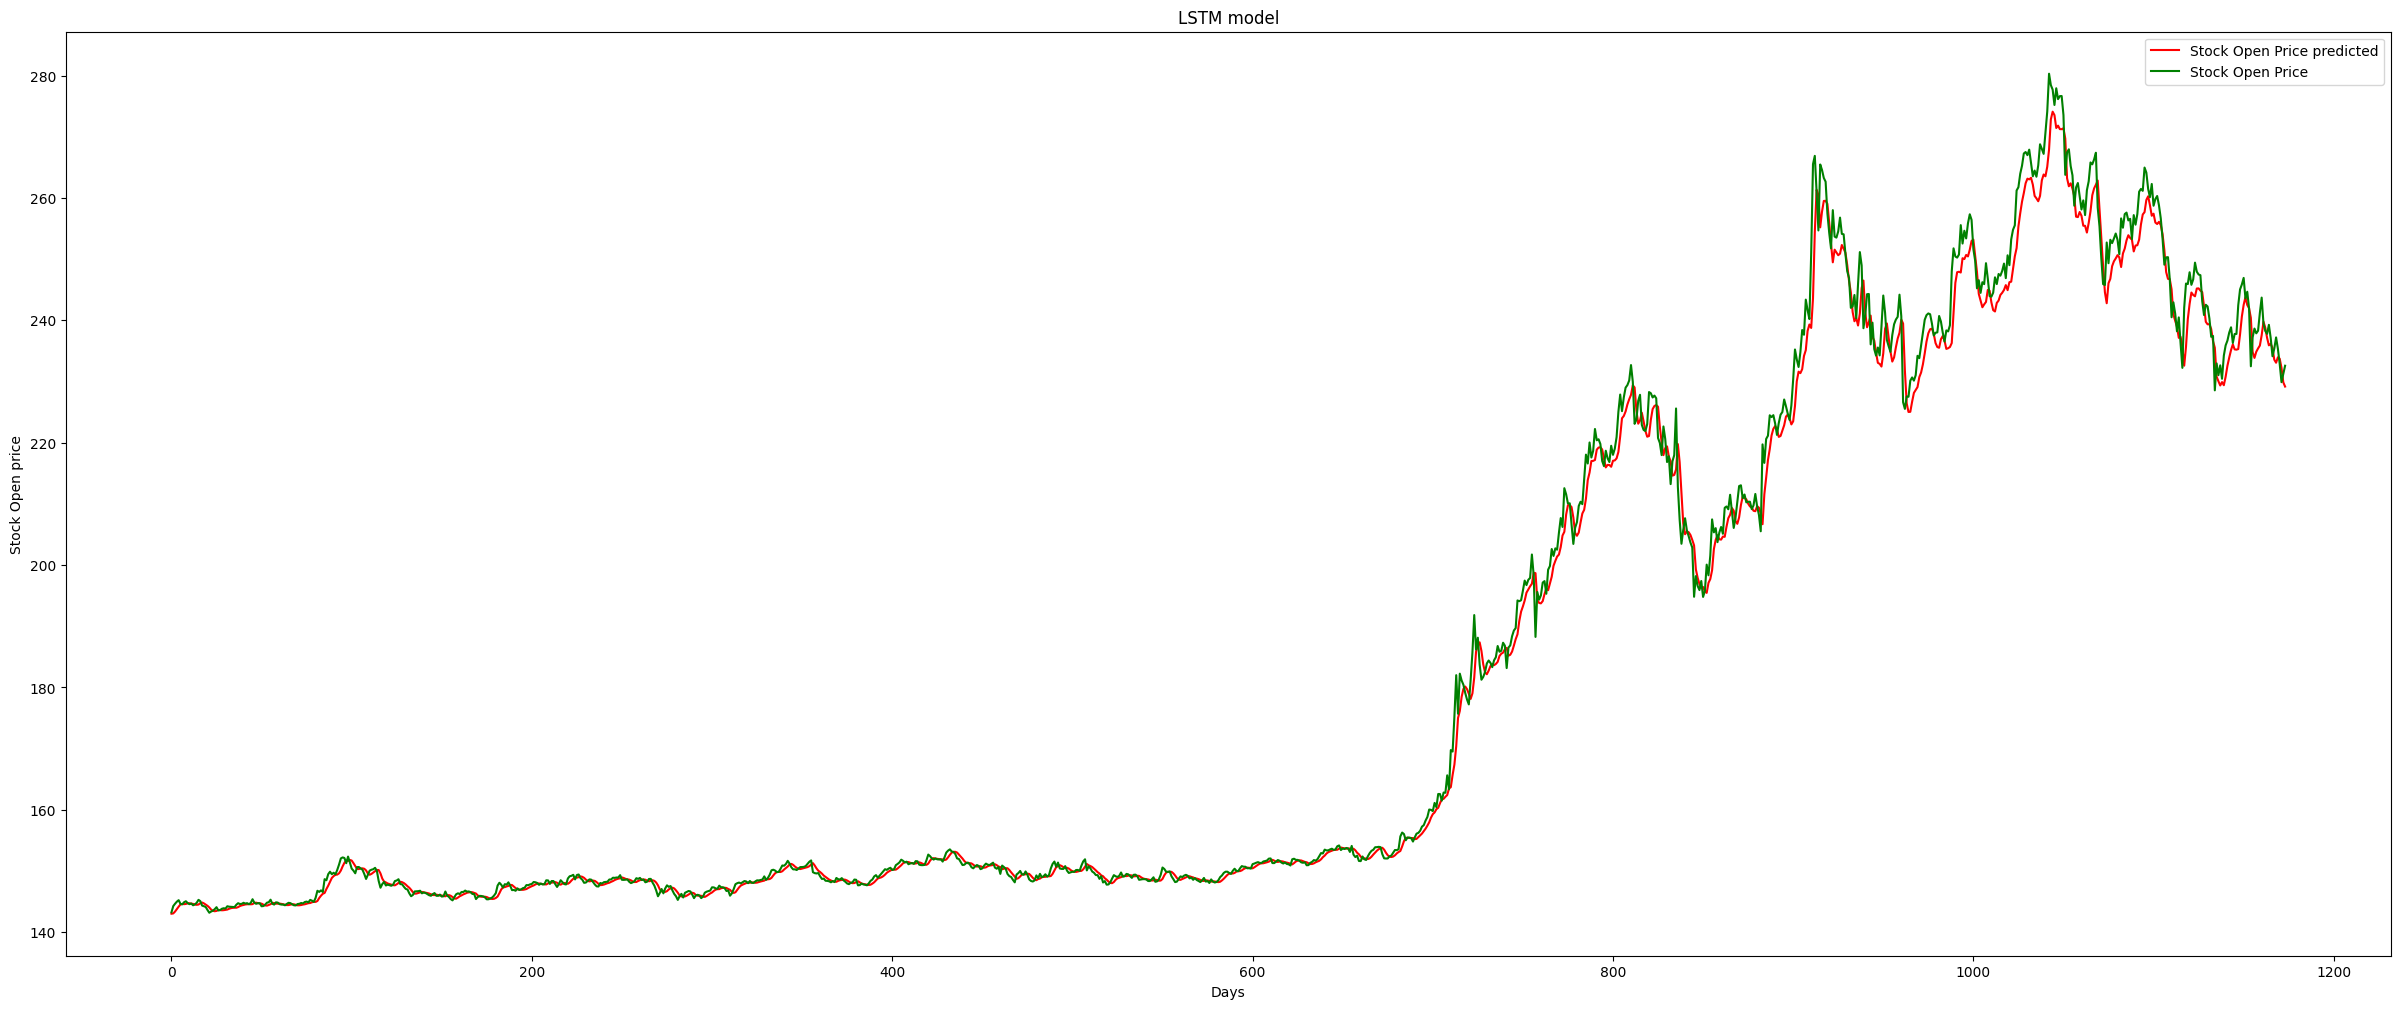

In [308]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_train)), label = "Stock Open Price predicted", c = "red" )
plt.plot(scaler.inverse_transform(y_train), label = "Stock Open Price", color = "green")
plt.xlabel("Days")
plt.ylabel("Stock Open price")
plt.title("LSTM model")
plt.legend()
plt.show()

In [309]:
# predictions with X_test data
y_pred_lstm_test = model_lstm.predict(X_test)
# scaling back from 0-1 to original
y_pred_lstm_test = scaler.inverse_transform(y_pred_lstm_test)
print("Shape of y_pred_of_test :",y_pred_lstm_test.shape)

16/16 [==============================] - 0s 3ms/step
Shape of y_pred_of_test : (498, 1)


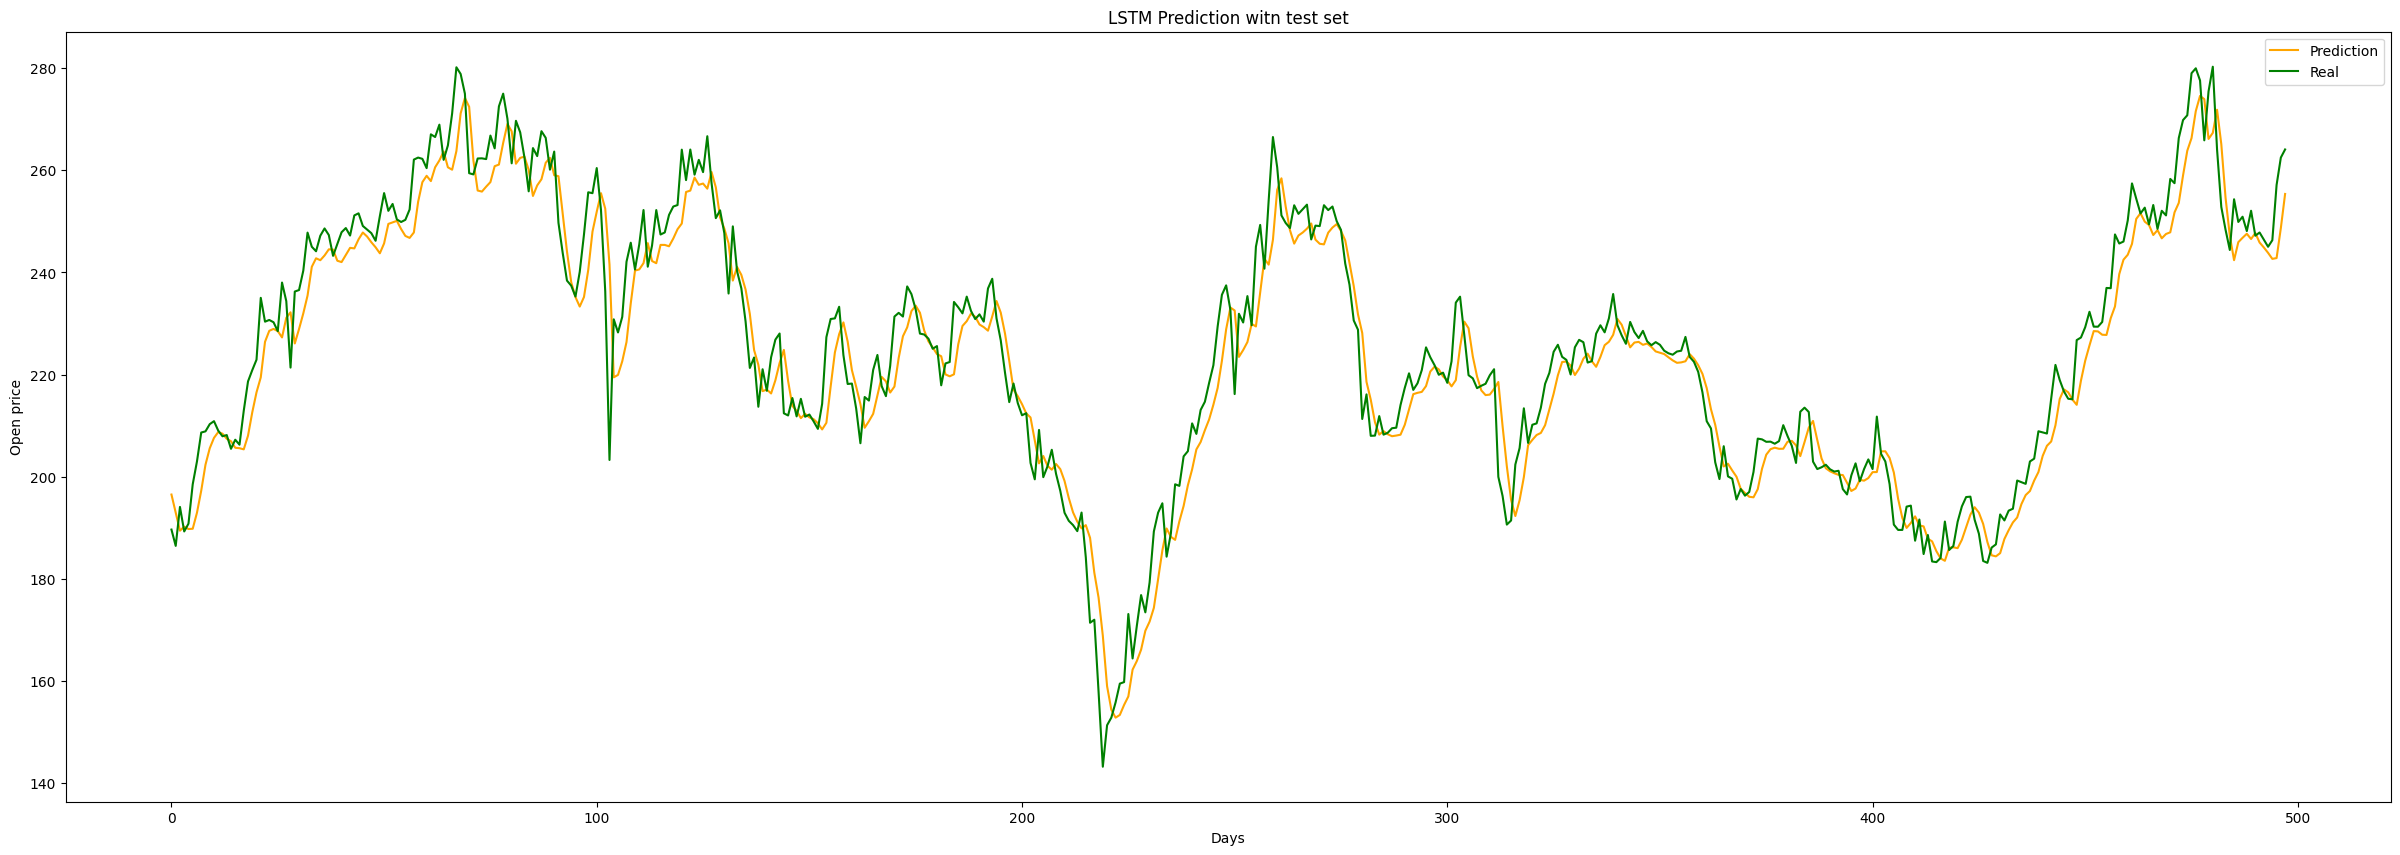

In [310]:
# visualisation
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_lstm_test, label = "Prediction", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "Real", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM Prediction witn test set")
plt.legend()
plt.show()